In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
import time

In [145]:
x_encoder = OneHotEncoder(
    categories=[
        # age group
        ['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years'],
        # exposure_yn
        ['Missing', 'Unknown', 'Yes'],
        # race
        [
            'American Indian/Alaska Native', 'Asian', 'Black',
            'Multiple/Other', 'Native Hawaiian/Other Pacific Islander', 'White'
        ],
        # sex
        ['Female', 'Male'],
        # state fips code
        [*range(1, 79)],
        # underlying_conditions_yn
        ['No', 'Yes'],
    ],
    handle_unknown='error',
)

y_encoder = OrdinalEncoder(
    categories=[
        ['No', 'Yes'],
    ],
    handle_unknown='error',
)


def open_csv_file(filename='data_train.csv', chunksize=2048):
    return pd.read_csv(filename,
                       chunksize=chunksize,
                       low_memory=False,
                       skiprows=lambda i: i > 0 and random.random() > 0.1)


def read_next_chunk(df):
    x = next(df)
    x.drop('Unnamed: 0', axis=1, inplace=True)

    y = x.pop('death_yn')

    x = x_encoder.fit_transform(x)
    y = y_encoder.fit_transform(y.values.reshape(-1, 1)).ravel()
    return (x, y)


read_next_chunk(open_csv_file(chunksize=16))

(<16x95 sparse matrix of type '<class 'numpy.float64'>'
 	with 96 stored elements in Compressed Sparse Row format>,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [146]:
def benchmark(model):
    df = open_csv_file(filename='data_test.csv', chunksize=16384)
    x, y_true = read_next_chunk(df)
    y_pred = model.predict(x)

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred).plot()

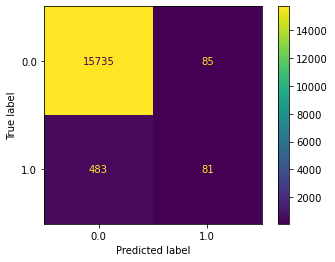

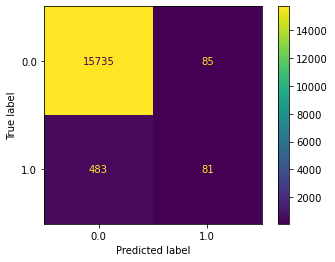

In [157]:
def knn():
    df = open_csv_file()
    knn = KNeighborsClassifier(n_neighbors=5)

    start = time.time()
    count = 0
    try:
        while True:
            x, y_true = read_next_chunk(df)
            count += y_true.shape[0]
            knn.fit(x, y_true)
    except StopIteration:
        pass

    return knn


benchmark(knn())

91961 rows processed in 1.08949613571167 seconds


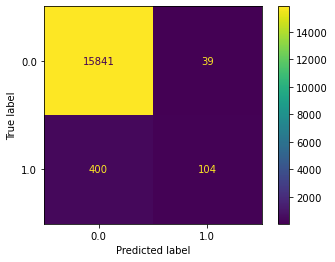

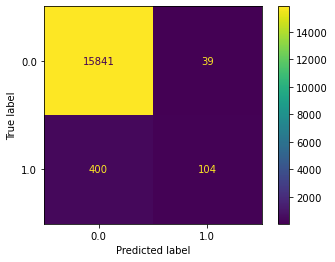

In [149]:
def svm_rbf():
    df = open_csv_file()
    svm = SVC(kernel='rbf')

    start = time.time()
    count = 0
    try:
        while True:
            x, y = read_next_chunk(df)
            count += y.shape[0]
            svm.fit(x, y)
    except StopIteration:
        pass
    print(f'{count} rows processed in {time.time() - start} seconds')

    return svm


benchmark(svm_rbf())